# Setup-Env

In [ ]:
%%capture
!pip install geohash2 lightgbm==4.3.0 pytorch_lightning==2.2.5 geopy==2.4.1 xgboost==1.7.6 catboost==1.2.5

# Imports

In [ ]:
%matplotlib inline
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
from datetime import date
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
import xgboost as xgb
from xgboost import DMatrix, train
np.random.seed(42)
import math
import random
from geopy.distance import geodesic
import geohash2 as gh
from geopy.distance import great_circle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from xgboost import DMatrix, train
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping
import numpy as np
import torchmetrics
import os
from geopy.distance import geodesic
from catboost import CatBoostRegressor, Pool

# Utils

In [41]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

In [42]:
def remove_outliers_from_target(df, target_column, threshold=3):
    mean = df[target_column].mean()
    std_dev = df[target_column].std()
    df['z_score'] = (df[target_column] - mean) / std_dev
    print(df[abs(df['z_score']) >= threshold].shape)
    df = df[abs(df['z_score']) < threshold]
    df = df.drop(columns=['z_score'])
    return df

In [43]:
def fillna(df,CFG):
    nan_columns = df.columns[df.isna().any()].tolist()
    nan_columns.remove(CFG.data_preparation.target)
    for col in nan_columns:
        df[col] = df[col].fillna(df.groupby([CFG.data_preparation.fillna.col])[col].transform(CFG.data_preparation.fillna.sta))
    return df 

In [44]:
def groupby_features(data,CFG):
    for col in CFG.data_preparation.group_by.cols:
        data[f"{col}__mean"] = data.groupby(col)[CFG.data_preparation.group_by.target].transform('mean')
        data[f"{col}__std"] = data.groupby(col)[CFG.data_preparation.group_by.target].transform('std')
        data[f"{col}__min"] = data.groupby(col)[CFG.data_preparation.group_by.target].transform('min')
        data[f"{col}__max"] = data.groupby(col)[CFG.data_preparation.group_by.target].transform('max')
        data[f"{col}__skew"] = data.groupby(col)[CFG.data_preparation.group_by.target].transform('skew')
    return data


def groupby_featuresb_many(data, CFG):
        data[f"{feat}__mean"] = data.groupby(CFG.data_preparation.group_by_many.stats_feats)[CFG.data_preparation.group_by_many.target].transform('mean')
        data[f"{feat}__std"] = data.groupby(CFG.data_preparation.group_by_many.stats_feats)[CFG.data_preparation.group_by_many.target].transform('std')
        data[f"{feat}__min"] = data.groupby(CFG.data_preparation.group_by_many.stats_feats)[CFG.data_preparation.group_by_many.target].transform('min')
        data[f"{feat}__max"] = data.groupby(CFG.data_preparation.group_by_many.stats_feats)[CFG.data_preparation.group_by_many.target].transform('max')
        data[f"{feat}__skew"] = data.groupby(CFG.data_preparation.group_by_many.stats_feats)[CFG.data_preparation.group_by_many.target].transform('skew')
        return data

In [45]:
def local(df):
    l1 = ['Accra', 'Lagos', 'Yaoundé']
    l2 = ['Bujumbura', 'Gulu', 'Kampala', 'Kisumu', 'Nairobi']
    df.loc[df['city'].isin(l1), 'local'] = 'l1'
    df.loc[df['city'].isin(l2), 'local'] = 'l2'
    return df


def geohash(df,CFG):
    df['geohash'] = df.apply(lambda row: gh.encode(row['site_latitude'], row['site_longitude'], precision=CFG.data_preparation.precision), axis=1)
    return df

In [46]:
def Extract_time_features(df):
    df['date']=pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['date'].dt.dayofweek > 4 
    return df

In [47]:
def count(df,CFG):
    for i in CFG.data_preparation.counts:
        df['count_'+i] = df[i].map(df[i].value_counts())
    return df 

In [48]:
def encoder(df,CFG):
    label_encoder = LabelEncoder()
    for col in CFG.data_preparation.label_enco.cols:
        df[col] = label_encoder.fit_transform(df[col])
    return df


def cat(df,CFG):
    for col in CFG.data_preparation.categorical_features:
        df[col]=df[col].astype('category')
    return df

In [49]:
def get_dist(row):
    Industrial_zones=dict()
    Industrial_zones['Nairobi']=(-1.3061, 36.8605)
    Industrial_zones['Kampala']=(0.3128, 32.5828)
    Industrial_zones['Bujumbura']= (-3.36194, 29.35638)
    Industrial_zones['Lagos']= (6.474167, 3.38084)
    Industrial_zones['Kisumu']=(-0.08472, 34.75889)
    Industrial_zones['Gulu']=(2.77194, 32.29694)
    Industrial_zones['Yaoundé']= (3.86167, 11.51889)
    Industrial_zones['Accra']= (5.57528, -0.22056)
    row['dist_city']=geodesic(Industrial_zones[row['city']],(row['site_latitude'],row['site_longitude'])).kilometers
    return row

In [50]:
def scaler(train,X,CFG):
    if CFG.data_preparation.Scaler=="StandardScaler":
        scaler= StandardScaler()
    else :
        scaler = MinMaxScaler()
    scaled_features =scaler.fit_transform(X.values)
    X= pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
    for col in CFG.data_preparation.categorical_features:
        X[col]=train[col]
    return X

In [51]:
def plot_feature_importance_xgb(model):
    plt.figure(figsize=(30, 30))
    xgb.plot_importance(model,max_num_features=25)
    plt.show()
    
    
from xgboost import DMatrix, train
def xgboost_model(CFG,X,y,test):
    pred_test=[]
    pred_val=[]    
    scoor_val_MAE=[]
    scoor_val_RMSE=[]
    scoor_train_MAE=[]
    scoor_train_RMSE=[]
    params = CFG.train_xgb.params 
    folds=CFG.train_xgb.folds 
    folds = GroupKFold(n_splits=folds)
    for fold_num, (train_index, test_index) in enumerate(folds.split(X,y, groups=X[CFG.train_xgb.col_by])):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        dtrain = DMatrix(X_train, label=y_train,enable_categorical=True)
        dval = DMatrix(X_val, label=y_val,enable_categorical=True)
        dtest=DMatrix(test,enable_categorical=True)
        bst = train(
                    params,
                    dtrain,
                    num_boost_round=CFG.train_xgb.num_boost_round,
                    early_stopping_rounds=CFG.train_xgb.early_stopping_rounds,
                    verbose_eval=CFG.train_xgb.verbose_eval,
                    evals=[(dtrain, 'train'), (dval, 'val')]
                    )
        best_iteration = bst.best_iteration
        y_pred_val = bst.predict(dval,iteration_range=(0, best_iteration))
        y_train_pred = bst.predict(dtrain,iteration_range=(0, best_iteration))
        pred_val.append(y_pred_val)
        MAE = mean_absolute_error(y_val, y_pred_val)
        MAE_train = mean_absolute_error(y_train, y_train_pred)
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred_val))
        RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        scoor_val_MAE.append(MAE)  
        scoor_val_RMSE.append(RMSE)  
        scoor_train_MAE.append(MAE_train)
        scoor_train_RMSE.append(RMSE_train)
        print(f"Fold {fold_num + 1} RMSE: {RMSE:.2f}")
        y_pred_test = bst.predict(dtest,iteration_range=(0, best_iteration))
        pred_test.append(y_pred_test)
    print('*****MAE_VAL*****',np.mean(scoor_val_MAE, axis=0))
    print('*****RMSE_val*****',np.mean(scoor_val_RMSE, axis=0))
    print('*****MAE_train*****',np.mean(scoor_train_MAE, axis=0))
    print('*****RMSE_train*****',np.mean(scoor_train_RMSE, axis=0))
    plot_feature_importance_xgb(bst)
    return bst,pred_test,np.mean(scoor_val_RMSE, axis=0),pred_val

In [52]:
def plot_feature_importance_cat(model):
    feature_importance = model.get_feature_importance()
    feature_names = model.feature_names_
    sorted_idx = feature_importance.argsort()[::-1]
    top_n = 25
    plt.figure(figsize=(10, 6))
    plt.bar(range(top_n), feature_importance[sorted_idx][:top_n], align='center')
    plt.xticks(range(top_n), [feature_names[i] for i in sorted_idx][:top_n], rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Feature Importance')
    plt.title('Top 25 Feature Importances')
    plt.show()
    
    
def creat_model_catboost(CFG,X,y,test):
    pred_test=[]
    scoor_val_MAE=[]
    scoor_val_RMSE=[]
    scoor_train_MAE=[]
    scoor_train_RMSE=[]
    pred_val=[]
    params = CFG.train_cat.params 
    folds=CFG.train_cat.folds 
    folds = GroupKFold(n_splits=folds)   
    for fold_num, (train_index, test_index) in enumerate(folds.split(X,y, groups=X[CFG.train_cat.col_by])):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        categorical_features_indices=CFG.train_cat.categorical_features_indices
        dtrain = Pool(X_train, 
                      label=y_train,
                      cat_features=categorical_features_indices
                     )
        dval = Pool(X_val, 
                    label=y_val,
                    cat_features=categorical_features_indices
                   )
        dtest = Pool(test,
                     cat_features=categorical_features_indices
                    )
        rf_regressor = CatBoostRegressor(**params)
        rf_regressor.fit(dtrain, 
                          eval_set=dval
                         )
        best_iteration = rf_regressor.get_best_iteration()
        y_val_pred = rf_regressor.predict(dval)
        y_train_pred = rf_regressor.predict(dtrain)
        pred_val.append(y_val_pred)
        MAE = mean_squared_error(y_val, y_val_pred)
        MAE_train = mean_squared_error(y_train, y_train_pred)
        RMSE = np.sqrt(mean_squared_error(y_val, y_val_pred))
        RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        scoor_val_MAE.append(MAE)  
        scoor_val_RMSE.append(RMSE)  
        scoor_train_MAE.append(MAE_train)
        scoor_train_RMSE.append(RMSE_train)
        print(f"Fold {fold_num + 1} MAE: {RMSE:.2f}")
        y_pred_test = rf_regressor.predict(dtest)
        pred_test.append(y_pred_test)
    print('*****MAE_VAL*****',np.mean(scoor_val_MAE, axis=0))
    print('*****RMSE_val*****',np.mean(scoor_val_RMSE, axis=0))
    print('*****MAE_train*****',np.mean(scoor_train_MAE, axis=0))
    print('*****RMSE_train*****',np.mean(scoor_train_RMSE, axis=0))    
    plot_feature_importance_cat(rf_regressor)
    return rf_regressor,pred_test,np.mean(scoor_val_RMSE, axis=0),pred_val

In [53]:
def plot_feature_importance_lgb(model):
    feature_importance = model.feature_importance(importance_type='gain')
    feature_names = model.feature_name()
    sorted_idx = np.argsort(feature_importance)[::-1]
    top_n = 25
    plt.figure(figsize=(10, 6))
    plt.bar(range(top_n), feature_importance[sorted_idx][:top_n], align='center')
    plt.xticks(range(top_n), [feature_names[i] for i in sorted_idx][:top_n], rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Feature Importance')
    plt.title('Top 25 Feature Importances')
    plt.show()
    
    
def create_model_lightgbm(CFG,X,y,test,mode):
    pred_test=[]
    scoor_val_MAE=[]
    scoor_val_RMSE=[]
    scoor_train_MAE=[]
    scoor_train_RMSE=[]    
    pred_val=[]
    params = mode.params 
    folds=mode.folds     
    folds = GroupKFold(n_splits=folds)
    for fold_num, (train_index, test_index) in enumerate(folds.split(X,y, groups=X[mode.col_by])):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        categorical_features_indices=mode.categorical_features_indices
        lgb_train = lgb.Dataset(X_train, 
                                label=y_train, 
                                categorical_feature=categorical_features_indices
                               )
        lgb_val = lgb.Dataset(X_val, 
                              label=y_val, 
                              reference=lgb_train, 
                              categorical_feature=categorical_features_indices
                             )
        lgb_test = lgb.Dataset(test, 
                               categorical_feature=categorical_features_indices
                              )
        gbm = lgb.train(params,
                        lgb_train,
                        valid_sets=[lgb_val],
                        )
        y_pred_val = gbm.predict(X_val)
        y_train_pred = gbm.predict(X_train)
        pred_val.append(y_pred_val)
        MAE = mean_absolute_error(y_val, y_pred_val)
        MAE_train = mean_absolute_error(y_train, y_train_pred)
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred_val))
        RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        scoor_val_MAE.append(MAE)  
        scoor_val_RMSE.append(RMSE)  
        scoor_train_MAE.append(MAE_train)
        scoor_train_RMSE.append(RMSE_train)
        print(f"Fold {fold_num + 1} RMSE: {RMSE:.2f}")
        y_pred_test = gbm.predict(test)
        pred_test.append(y_pred_test)
    print('*****MAE_VAL*****',np.mean(scoor_val_MAE, axis=0))
    print('*****RMSE_val*****',np.mean(scoor_val_RMSE, axis=0))
    print('*****MAE_train*****',np.mean(scoor_train_MAE, axis=0))
    print('*****RMSE_train*****',np.mean(scoor_train_RMSE, axis=0))        
    plot_feature_importance_lgb(gbm)    
    return gbm,pred_test,np.mean(scoor_val_RMSE, axis=0),pred_val

In [54]:
class CustomDataset(Dataset):
    def __init__(self, X, y, cat_features, cat_emb_indices):
        self.X = X
        self.y = y
        self.cat_features = cat_features
        self.cat_emb_indices = cat_emb_indices

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_num = self.X.iloc[idx].drop(self.cat_features).values.astype(np.float32)
        x_cat = self.X.iloc[idx][self.cat_features].values.astype(np.int64)
        return (x_num, x_cat), self.y.iloc[idx].astype(np.float32)
    
    
class ModelConfig:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    
    def __getitem__(self, key):
        return self.__dict__[key]

    
class DNNModel(LightningModule):
    def __init__(self, config, cat_dims, emb_dims):
        super(DNNModel, self).__init__()
        self.config = config
        self.cat_dims = cat_dims
        self.emb_dims = emb_dims
        self.embeddings = nn.ModuleList([nn.Embedding(dim, emb_dim) for dim, emb_dim in zip(cat_dims, emb_dims)])
        input_dim = self.config['input_dim'] + sum(emb_dims)
        layers = []
        for units, dropout, batch_norm in self.config['dnn_params']['hidden_units']:
            layers.append(nn.Linear(input_dim, units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = units
        layers.append(nn.Linear(input_dim, 1))
        self.model = nn.Sequential(*layers)
        self.loss_fn = nn.L1Loss()
        self.metrics_val=torchmetrics.MeanSquaredError(squared=False)
        self.metrics_train=torchmetrics.MeanSquaredError(squared=False)

    def forward(self, x):
        set_seed(seed=CFG.train_NN.seed)
        x_num, x_cat = x
        x_cat_emb = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x_cat_emb = torch.cat(x_cat_emb, dim=1)
        x = torch.cat([x_num, x_cat_emb], dim=1)
        return self.model(x).squeeze(1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.metrics_train.update(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.metrics_val.update(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def on_validation_epoch_end(self):
        train_mae = self.metrics_train.compute()
        self.log('train_RMSE', train_mae, prog_bar=True)
        self.metrics_train.reset()
        val_mae = self.metrics_val.compute()
        self.log('val_RMSE', val_mae, prog_bar=True)
        self.metrics_val.reset()
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.config['learning_rate'], weight_decay=self.config['weight_decay'])
        return optimizer


class Model:
    def __init__(self):
        self.nn_enabled = True
        self.batch_size = CFG.train_NN.batch_size
        self.epochs = CFG.train_NN.epochs
        self.valid_size = CFG.train_NN.valid_size
        self.estimators = CFG.train_NN.estimators
        self.is_fitted = False
        self.conf_dnn = ModelConfig(
            dnn_params={
                'hidden_units':CFG.train_NN.dnn_params.hidden_units,
                'dnn_activation': CFG.train_NN.dnn_params.dnn_activation,
            },
            learning_rate=CFG.train_NN.dnn_params.learning_rate,
            weight_decay=CFG.train_NN.dnn_params.weight_decay,
        )
        self.dnn_model = None

    def fit(self, X,y):
        if self.nn_enabled:
            set_seed(seed=CFG.train_NN.seed)
            categorical_features = X.select_dtypes(include=['object', 'category']).columns
            for col in categorical_features:
                X[col] = LabelEncoder().fit_transform(X[col])
            self.conf_dnn.input_dim = X.shape[1] - len(categorical_features)-1
            cat_dims = [X[col].nunique() for col in categorical_features]
            emb_dims = [min(50, (dim + 1) // 2) for dim in cat_dims]
            self.dnn_model = DNNModel(config=self.conf_dnn, cat_dims=cat_dims, emb_dims=emb_dims)
            train_X = X[X['fold'] == 0].drop(columns=['fold'])
            y_train = y[X['fold'] == 0]
            test_X = X[X['fold'] != 0].drop(columns=['fold'])
            y_test = y[X['fold'] != 0]
            dataset_train = CustomDataset(train_X, y_train, categorical_features, cat_dims)
            dataset_val = CustomDataset(test_X, y_test, categorical_features, cat_dims)
            train_loader = DataLoader(dataset_train, batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(dataset_val, batch_size=self.batch_size, shuffle=False)
            early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=True, mode='min')
            trainer = Trainer(max_epochs=self.epochs, callbacks=[early_stopping_callback])
            trainer.fit(self.dnn_model, train_loader, val_loader)
        self.is_fitted = True

    def predict(self, df_features):
        self.dnn_model.eval()
        categorical_features = df_features.select_dtypes(include=['object', 'category']).columns
        for col in categorical_features:
            df_features[col] = LabelEncoder().fit_transform(df_features[col])
        dataset = CustomDataset(df_features, pd.Series([0] * len(df_features)), categorical_features, self.dnn_model.cat_dims) 
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        predictions = []
        with torch.no_grad():
            for batch in loader:
                x, _ = batch
                preds = self.dnn_model(x)
                predictions.append(preds)
        predictions = torch.cat(predictions).numpy()
        predictions = np.clip(predictions, 0, np.inf)
        return predictions

In [55]:
def plot_pred(y,preds):
    sns.set_style("whitegrid")
    sns.set_context("notebook")
    fig, ax = plt.subplots(figsize=(10, 6))  
    y.plot.density(ax=ax, label='Training Set', color='y', linewidth=2.5)
    colors=['orange','blue','g','r','yellow']
    for i, (model,pred) in enumerate(preds.items()):
        pd.Series(pred).plot.density(ax=ax, label=model, color=colors[i], linewidth=2.5, linestyle='--')
    ax.set_title('Comparison of pm2_5 Density: Training vs. Predictions', fontsize=15)
    ax.set_xlabel('pm2_5 Density', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.tight_layout()
    plt.show()

In [79]:
class CFG:
    seed = 42
    device = 'cuda'
    class data_preparation:
        target='pm2_5'
        path_train='Train.csv'
        path_test='Test.csv'
        remove_nan=0.5
        precision=5
        Scaler="StandardScaler"
        categorical_features=['local','geohash','country']
        counts=['site_id','country','site_latitude','site_longitude','month']
        cols_droped=['city','date','id']
        class fillna:
            col='month'
            sta='mean'
        class group_by:
            cols=['month']
            target='pm2_5'
        class label_enco:
            cols=['site_id']
            
    class train_xgb:
        folds=10
        col_by='geohash'
        params={
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'lambda': 5,
            'max_depth': 8,
            'random_state':42,
            'tree_method': 'gpu_hist',
        }
        num_boost_round=1000
        early_stopping_rounds=20
        verbose_eval=50
   
    class train_cat:
        folds=5
        col_by='geohash'
        categorical_features_indices=['local','geohash','country']
        params = {
            'loss_function': 'RMSE',
            'iterations': 10000,
            'early_stopping_rounds': 100,
            'verbose': 50,
            'l2_leaf_reg': 5,
            'max_depth': 8,
            "random_state":42 ,
        }
    class train_lgb:
        folds=10
        col_by='geohash'
        categorical_features_indices=['local','geohash','country']
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'num_iterations': 1000,
            'early_stopping_round': 20,
            'num_leaves': 31,
            'learning_rate': 0.1,
            'reg_lambda': 5,
            'max_depth': 8,
            'random_state': 42,
            'tree_method': 'gpu_hist',
            'verbose_eval':50
            }
    class train_lgb_only:
        folds=10
        col_by='geohash'
        categorical_features_indices=['geohash']
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'num_iterations': 1000,
            'early_stopping_round': 20,
            'num_leaves': 31,
            'learning_rate': 0.1,
            'reg_lambda': 5,
            'max_depth': 8,
            'random_state': 42,
            'tree_method': 'gpu_hist',
            'verbose_eval':50
            }
        
    class train_NN:
        folds=5
        col_by='geohash'
        categorical_features_indices=['local','geohash','country']
        seed=0
        class dnn_params:
                hidden_units= [(32, 0.3, True),(64, 0.3, True),(128, 0.3, True),(256, 0.3, True), (128, 0.3, True),(64, 0.3, True),(32, 0.3, True)]
                dnn_activation='relu'
                learning_rate=1e-3
                weight_decay=9e-7
        batch_size =32
        epochs =100
        valid_size= 0.05
        estimators = 10
        
    class bagg:
        coef_xgb=0
        coef_lgb_only=0.2
        coef_lgb=0.2
        coef_NN=0.6

# Data

In [80]:
data=pd.read_csv(CFG.data_preparation.path_train)
test=pd.read_csv(CFG.data_preparation.path_test)

In [81]:
train_removed=data[data[CFG.data_preparation.target]<=200]
df=pd.concat([train_removed,test],axis=0)
threshold = len(data) * CFG.data_preparation.remove_nan
df.dropna(axis=1, inplace=True, thresh=threshold)
df=fillna(df,CFG)
df=df.apply(get_dist,axis=1)
df=Extract_time_features(df)

In [82]:
df=local(df)
df=geohash(df,CFG)
df=groupby_features(df,CFG)
df=count(df,CFG)
df=df.drop(CFG.data_preparation.cols_droped,axis=1)
df=encoder(df,CFG)
df=cat(df,CFG)

In [83]:
data=df[(~df[CFG.data_preparation.target].isna())]
test=df[(df[CFG.data_preparation.target].isna())]

In [84]:
X=data.drop([CFG.data_preparation.target]+CFG.data_preparation.categorical_features,axis=1)
y=data[CFG.data_preparation.target]
test1=test.drop([CFG.data_preparation.target]+CFG.data_preparation.categorical_features,axis=1)

In [85]:
X=scaler(data,X,CFG)
test1=scaler(test,test1,CFG)

In [86]:
X.head()

,site_id,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,dist_city,year,day,day_of_week,is_weekend,month__mean,month__std,month__min,month__max,month__skew,count_site_id,count_country,count_site_latitude,count_site_longitude,count_month,local,geohash,country
0,2.679093,2.775475,-2.902223,2.628230,0.105321,1.200428,0.141733,-0.206780,0.603438,0.454997,-0.678082,-0.473534,0.087817,1.141432,-0.396601,0.364533,0.009168,-1.230137,0.217764,0.094003,-0.620005,-0.153661,-0.171301,-0.208713,0.447308,0.042567,0.302294,-0.212728,0.032388,-1.552960,0.519523,0.255235,-0.636156,-0.385592,-0.242151,0.683594,-0.111806,-0.183104,-0.352600,-0.665127,0.274395,0.417521,0.659105,-2.191040,-1.020278,-1.037515,-0.841730,0.777319,0.991211,-0.846003,-0.620945,0.654264,1.070937,-1.018891,-1.045993,-0.844706,0.776949,-0.150866,0.024737,-0.016195,0.021679,-0.014696,0.021382,-0.079957,0.056087,-0.118688,-0.574380,-0.042097,0.166971,-0.328753,1.138168,-0.581389,-0.628299,-0.847786,-0.049504,-0.806998,0.959380,0.758207,-1.976498,-2.113793,-2.008372,-1.976498,-0.406714,l1,s14mj,Nigeria
1,2.679093,2.775475,-2.902223,1.393314,-0.124580,0.053155,-0.147969,0.418200,-0.203265,-0.205539,-0.972244,1.017586,-0.136232,1.434407,1.178897,2.193773,1.305507,-3.607014,1.245822,1.507114,-1.335820,-0.302704,-0.153006,-0.240327,0.747695,-0.081345,0.088292,-0.044938,0.349298,-0.977940,-0.253030,-0.150829,-0.958033,1.083008,0.381754,2.194672,1.333265,1.668165,-0.226672,-1.301392,1.364303,1.199373,0.171718,-2.862604,0.965001,0.941549,-1.324747,-0.264818,-0.175064,0.975243,0.936129,0.008867,-0.418847,0.979450,0.959135,-1.329065,-0.285477,0.276813,-0.083694,0.095194,-0.086343,0.096488,0.279564,0.026657,0.061370,0.402284,-0.999300,0.810914,0.166971,-0.328753,-1.475521,-0.053224,-0.628299,-0.657895,0.693670,-1.142444,1.385553,1.517135,-1.976498,-2.113793,-2.008372

# Training

[0]	train-rmse:22.40524	val-rmse:21.78601

[43]	train-rmse:3.42750	val-rmse:10.85747

Fold 1 RMSE: 10.77

[0]	train-rmse:22.25330	val-rmse:21.00284

[30]	train-rmse:4.25024	val-rmse:12.17270

Fold 2 RMSE: 12.01

[0]	train-rmse:21.76521	val-rmse:27.67534

[50]	train-rmse:3.18837	val-rmse:18.20759

[100]	train-rmse:1.67359	val-rmse:18.10259

[150]	train-rmse:1.06453	val-rmse:18.03880

[166]	train-rmse:0.88171	val-rmse:18.05002

Fold 3 RMSE: 18.04

[0]	train-rmse:22.26124	val-rmse:20.52637

[45]	train-rmse:3.46650	val-rmse:8.33837

Fold 4 RMSE: 8.29

[0]	train-rmse:21.98523	val-rmse:22.74687

[34]	train-rmse:4.24861	val-rmse:14.65500

Fold 5 RMSE: 14.24

[0]	train-rmse:22.08554	val-rmse:22.54809

[50]	train-rmse:3.30164	val-rmse:14.08420

[100]	train-rmse:1.85487	val-rmse:13.79781

[150]	train-rmse:1.17434	val-rmse:13.77141

[200]	train-rmse:0.69420	val-rmse:13.74652

[250]	train-rmse:0.45944	val-rmse:13.73235

[300]	train-rmse:0.32111	val-rmse:13.72016

[350]	train-rmse:0.22202	val-rmse:

<Figure size 3000x3000 with 0 Axes>

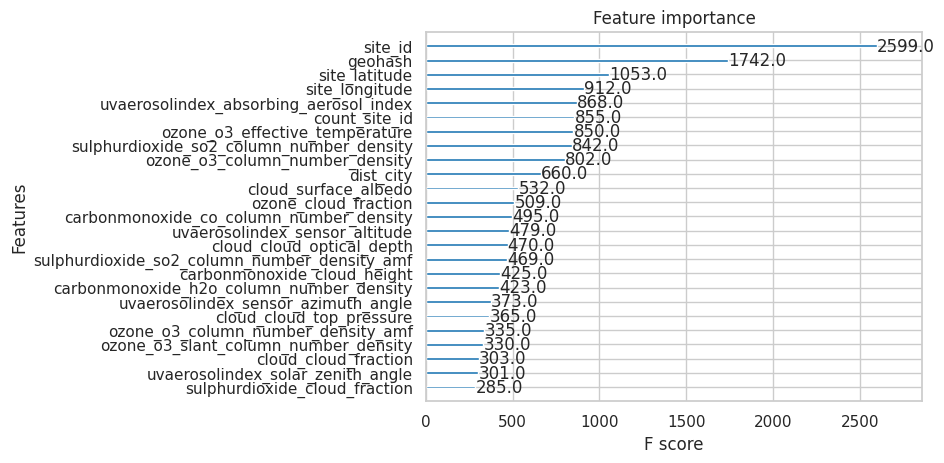

In [64]:
model_xgb,pred_xgb,CV_xgb,pred_val_xgb=xgboost_model(CFG,X,y,test1)

In [65]:
#model_catboost,pred_catboost,CV_catboost,pred_val_cat=creat_model_catboost(CFG,X,y,test1)

[LightGBM] [Warning] Unknown parameter: verbose_eval

[LightGBM] [Warning] Unknown parameter: tree_method

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

[LightGBM] [Warning] Unknown parameter: verbose_eval

[LightGBM] [Warning] Unknown parameter: tree_method

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.

You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 16634

[LightGBM] [Info] Number of data points in the train set: 6714, number of used features: 82

[LightGBM] [Warning] Unknown parameter: verbose_eval

[LightGBM] [Warning] Unknown parameter: tree_method

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves

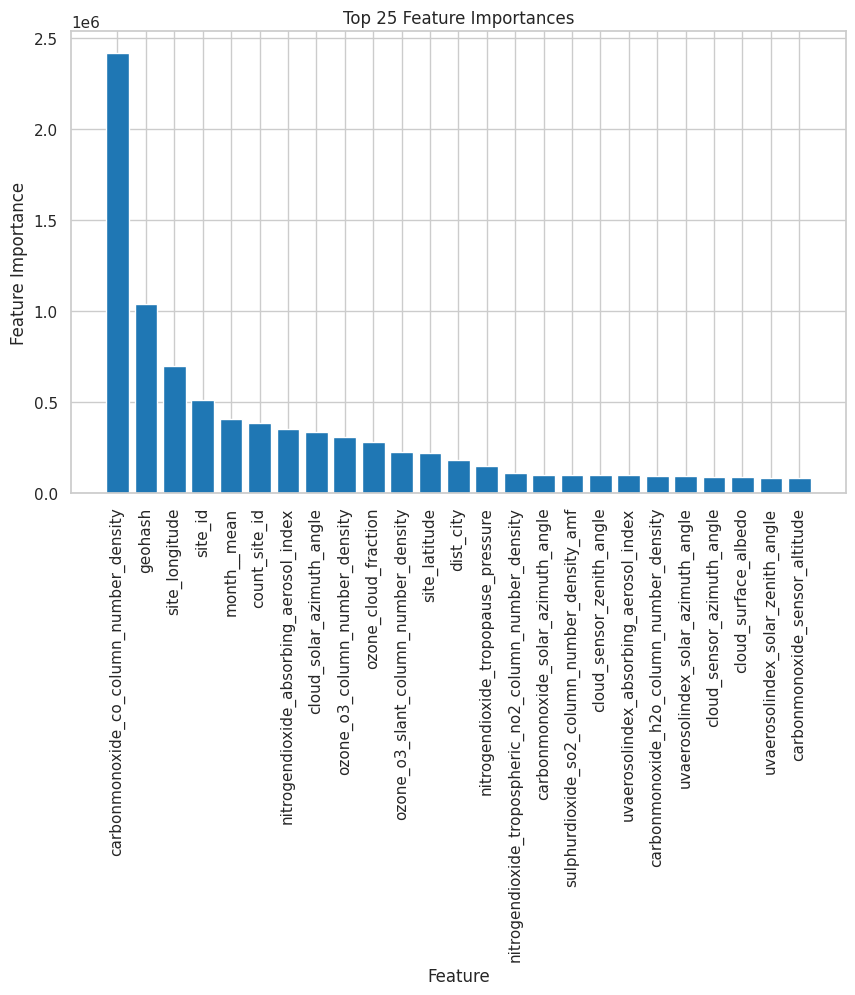

In [66]:
model_lightgbm,pred_lightgbm,CV_lightgbm,pred_val_ligh=create_model_lightgbm(CFG,X,y,test1,CFG.train_lgb)

[LightGBM] [Warning] Unknown parameter: verbose_eval

[LightGBM] [Warning] Unknown parameter: tree_method

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

[LightGBM] [Warning] Unknown parameter: verbose_eval

[LightGBM] [Warning] Unknown parameter: tree_method

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001812 seconds.

You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 16164

[LightGBM] [Info] Number of data points in the train set: 6714, number of used features: 65

[LightGBM] [Warning] Unknown parameter: verbose_eval

[LightGBM] [Warning] Unknown parameter: tree_method

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves

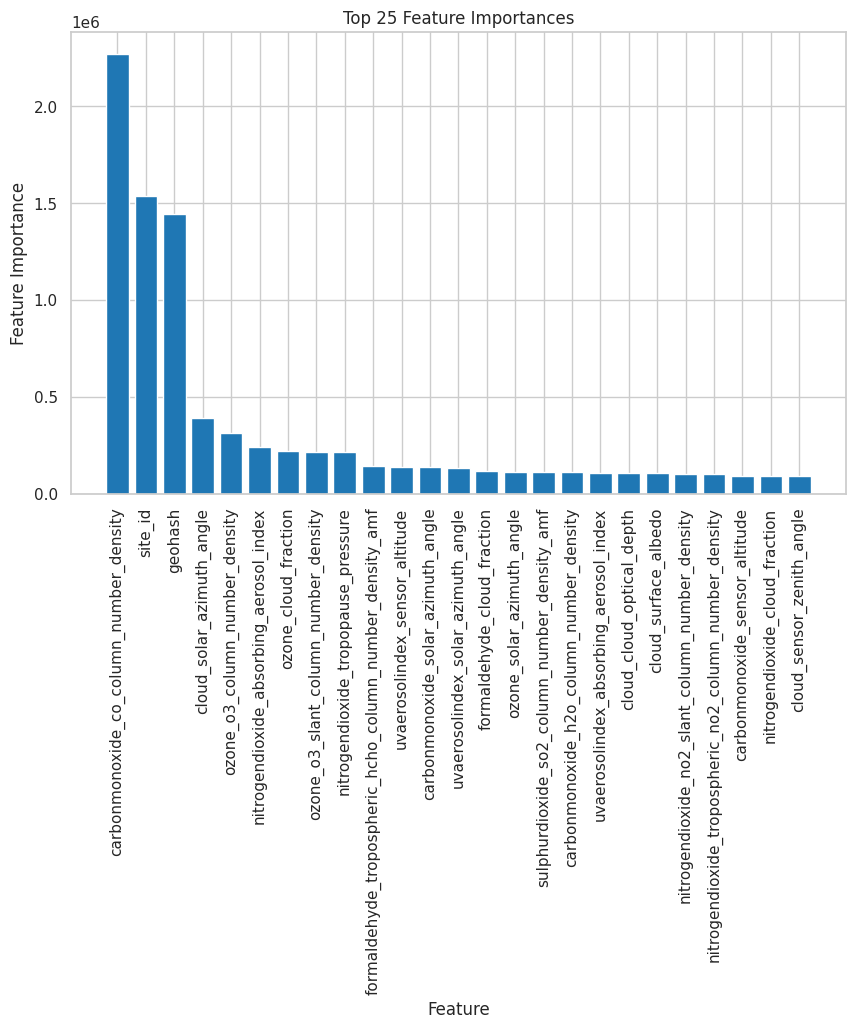

In [67]:
X2=X[['sulphurdioxide_so2_column_number_density',
                           'sulphurdioxide_so2_column_number_density_amf',
                           'sulphurdioxide_so2_slant_column_number_density',
                           'sulphurdioxide_cloud_fraction',
                           'sulphurdioxide_sensor_azimuth_angle',
                           'sulphurdioxide_sensor_zenith_angle',
                           'sulphurdioxide_solar_azimuth_angle',
                           'sulphurdioxide_solar_zenith_angle',
                           'sulphurdioxide_so2_column_number_density_15km',
                            'carbonmonoxide_co_column_number_density',
                           'carbonmonoxide_h2o_column_number_density',
                           'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
                           'carbonmonoxide_sensor_azimuth_angle',
                           'carbonmonoxide_sensor_zenith_angle',
                           'carbonmonoxide_solar_azimuth_angle',
                           'carbonmonoxide_solar_zenith_angle',
                            'nitrogendioxide_no2_column_number_density',
                           'nitrogendioxide_tropospheric_no2_column_number_density',
                           'nitrogendioxide_stratospheric_no2_column_number_density',
                           'nitrogendioxide_no2_slant_column_number_density',
                           'nitrogendioxide_tropopause_pressure',
                           'nitrogendioxide_absorbing_aerosol_index',
                           'nitrogendioxide_cloud_fraction', 'nitrogendioxide_sensor_altitude',
                           'nitrogendioxide_sensor_azimuth_angle',
                           'nitrogendioxide_sensor_zenith_angle',
                           'nitrogendioxide_solar_azimuth_angle',
                            'nitrogendioxide_solar_zenith_angle',
                            'formaldehyde_tropospheric_hcho_column_number_density',
                           'formaldehyde_tropospheric_hcho_column_number_density_amf',
                           'formaldehyde_hcho_slant_column_number_density',
                           'formaldehyde_cloud_fraction', 'formaldehyde_solar_zenith_angle',
                           'formaldehyde_solar_azimuth_angle', 'formaldehyde_sensor_zenith_angle',
                           'formaldehyde_sensor_azimuth_angle',                  
                             'uvaerosolindex_absorbing_aerosol_index',
                           'uvaerosolindex_sensor_altitude', 'uvaerosolindex_sensor_azimuth_angle',
                           'uvaerosolindex_sensor_zenith_angle',
                           'uvaerosolindex_solar_azimuth_angle',
                           'uvaerosolindex_solar_zenith_angle',                
                             'ozone_o3_column_number_density',
                           'ozone_o3_column_number_density_amf',
                           'ozone_o3_slant_column_number_density',
                           'ozone_o3_effective_temperature', 'ozone_cloud_fraction',
                           'ozone_sensor_azimuth_angle', 'ozone_sensor_zenith_angle',
                           'ozone_solar_azimuth_angle', 'ozone_solar_zenith_angle',              
                             'cloud_cloud_fraction', 'cloud_cloud_top_pressure',
                           'cloud_cloud_top_height', 'cloud_cloud_base_pressure',
                           'cloud_cloud_base_height', 'cloud_cloud_optical_depth',
                           'cloud_surface_albedo', 'cloud_sensor_azimuth_angle',  'cloud_sensor_zenith_angle', 'cloud_solar_azimuth_angle',
                           'cloud_solar_zenith_angle','geohash','site_id']]
test2=test1[['sulphurdioxide_so2_column_number_density',
                           'sulphurdioxide_so2_column_number_density_amf',
                           'sulphurdioxide_so2_slant_column_number_density',
                           'sulphurdioxide_cloud_fraction',
                           'sulphurdioxide_sensor_azimuth_angle',
                           'sulphurdioxide_sensor_zenith_angle',
                           'sulphurdioxide_solar_azimuth_angle',
                           'sulphurdioxide_solar_zenith_angle',
                           'sulphurdioxide_so2_column_number_density_15km',
                            'carbonmonoxide_co_column_number_density',
                           'carbonmonoxide_h2o_column_number_density',
                           'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
                           'carbonmonoxide_sensor_azimuth_angle',
                           'carbonmonoxide_sensor_zenith_angle',
                           'carbonmonoxide_solar_azimuth_angle',
                           'carbonmonoxide_solar_zenith_angle',
                            'nitrogendioxide_no2_column_number_density',
                           'nitrogendioxide_tropospheric_no2_column_number_density',
                           'nitrogendioxide_stratospheric_no2_column_number_density',
                           'nitrogendioxide_no2_slant_column_number_density',
                           'nitrogendioxide_tropopause_pressure',
                           'nitrogendioxide_absorbing_aerosol_index',
                           'nitrogendioxide_cloud_fraction', 'nitrogendioxide_sensor_altitude',
                           'nitrogendioxide_sensor_azimuth_angle',
                           'nitrogendioxide_sensor_zenith_angle',
                           'nitrogendioxide_solar_azimuth_angle',
                            'nitrogendioxide_solar_zenith_angle',
                            'formaldehyde_tropospheric_hcho_column_number_density',
                           'formaldehyde_tropospheric_hcho_column_number_density_amf',
                           'formaldehyde_hcho_slant_column_number_density',
                           'formaldehyde_cloud_fraction', 'formaldehyde_solar_zenith_angle',
                           'formaldehyde_solar_azimuth_angle', 'formaldehyde_sensor_zenith_angle',
                           'formaldehyde_sensor_azimuth_angle',                  
                             'uvaerosolindex_absorbing_aerosol_index',
                           'uvaerosolindex_sensor_altitude', 'uvaerosolindex_sensor_azimuth_angle',
                           'uvaerosolindex_sensor_zenith_angle',
                           'uvaerosolindex_solar_azimuth_angle',
                           'uvaerosolindex_solar_zenith_angle',                
                             'ozone_o3_column_number_density',
                           'ozone_o3_column_number_density_amf',
                           'ozone_o3_slant_column_number_density',
                           'ozone_o3_effective_temperature', 'ozone_cloud_fraction',
                           'ozone_sensor_azimuth_angle', 'ozone_sensor_zenith_angle',
                           'ozone_solar_azimuth_angle', 'ozone_solar_zenith_angle',              
                             'cloud_cloud_fraction', 'cloud_cloud_top_pressure',
                           'cloud_cloud_top_height', 'cloud_cloud_base_pressure',
                           'cloud_cloud_base_height', 'cloud_cloud_optical_depth',
                           'cloud_surface_albedo', 'cloud_sensor_azimuth_angle',  'cloud_sensor_zenith_angle', 'cloud_solar_azimuth_angle',
                           'cloud_solar_zenith_angle','geohash','site_id']]

model_lightgbm_only,pred_lightgbm_only,CV_lightgbm_only,pred_val_ligh_only=create_model_lightgbm(CFG,X2,y,test2,CFG.train_lgb_only)

In [68]:
if CFG.bagg.coef_NN!=0:
    X=X.reset_index(drop=True)
    X1=X.copy()
    y=y.reset_index(drop=True)
    test2=test1.reset_index(drop=True)
    X1['fold']=0
    folds=CFG.train_NN.folds
    folds = GroupKFold(n_splits=folds)
    preds_NN=[]
    scoor_train_NN=[]
    scoore_val_NN=[]
    for fold_num, (train_index, test_index) in enumerate(folds.split(X1,y, groups=X1[CFG.train_NN.col_by])):
            X1.loc[test_index,'fold'] = 1
            model = Model()
            model.fit(X1,y)
            X1=X1.reset_index(drop=True)
            y_train=model.predict(X[X1['fold']==0])
            y_val=model.predict(X[X1['fold']!=0])
            RMSE = np.sqrt(mean_squared_error(y_val, y[X1['fold']!=0]))
            RMSE_train = np.sqrt(mean_squared_error(y_train, y[X1['fold']==0]))
            print('val:',RMSE,'train',RMSE_train)
            scoor_train_NN.append(RMSE_train)
            scoore_val_NN.append(RMSE)
            y_pred_NN=model.predict(test2)
            preds_NN.append(y_pred_NN)
            X1=X.copy()
            X1=X1.reset_index(drop=True)
            y=y.reset_index(drop=True)
            test2=test1.reset_index(drop=True)
            X1['fold']=0
    CV_NN=np.mean(scoore_val_NN, axis=0)
    print('**************val:',CV_NN,'train',np.mean(scoor_train_NN, axis=0),'*************')

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

val: 12.838021310880823 train 14.3756939121347


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

val: 18.181199546807207 train 13.921577277171012


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

val: 16.77278541333229 train 15.022532000826047


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

val: 11.255942270923537 train 14.386062415274656


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

val: 14.055442426744124 train 14.143007632680545

**************val: 14.620678193737595 train 14.369774647617394 *************


# Evaluation 

In [74]:
print('XGB',CV_xgb)
print('lgb',CV_lightgbm)
print('lgb_only',CV_lightgbm_only)
print('NN',CV_NN)
print('pred',CV_xgb*CFG.bagg.coef_xgb+CV_lightgbm*CFG.bagg.coef_lgb+CV_lightgbm_only*CFG.bagg.coef_lgb_only+CV_NN*CFG.bagg.coef_NN) 

XGB 13.742233853482375

lgb 12.695197731956023

lgb_only 12.490844396056271

NN 14.620678193737595

pred 13.035847001669525


# Inference

In [75]:
y_xgb=np.mean(pred_xgb, axis=0)
y_lgb_only=np.mean(pred_lightgbm_only, axis=0)
y_lgb=np.mean(pred_lightgbm, axis=0)
y_NN=np.mean(preds_NN, axis=0)
pred=y_xgb*CFG.bagg.coef_xgb+y_lgb*CFG.bagg.coef_lgb+y_lgb_only*CFG.bagg.coef_lgb_only+y_NN*CFG.bagg.coef_NN

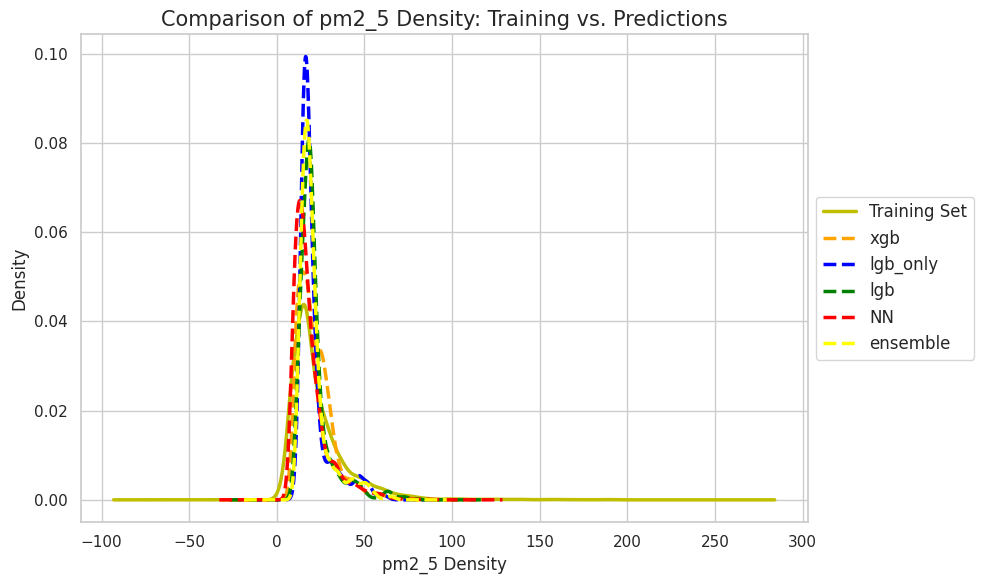

In [76]:
preds={'xgb':y_xgb,
      'lgb_only':y_lgb_only,
       'lgb':y_lgb,
       'NN':y_NN,
       'ensemble':pred
        }
plot_pred(y,preds)

In [77]:
sub=pd.read_csv('SampleSubmission.csv')
sub['pm2_5']=pred 
sub.to_csv('SampleSubmission.csv',index=False)

In [78]:
sub.head()

,id,pm2_5
0,id_ihxgrbq8bw,17.206426
1,id_dg6s4fhiwe,18.415581
2,id_f7hwwtmuzp,14.960167
3,id_ioese5awdg,16.649210
4,id_hdw320zpls,13.895777
